In [5]:
import sys, os
import mdp
import numpy as np
from gym.utils import seeding

if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    os.environ['DISPLAY'] = ':1'

In [6]:
try:
    from graphviz import Digraph
    import graphviz
    has_graphviz = True
except ImportError:
    has_graphviz = False


class MDP:
    def __init__(self, transition_probs, rewards, initial_state=None, seed=None):
        """
        Defines an MDP. Compatible with gym Env.
        :param transition_probs: transition_probs[s][a][s_next] = P(s_next | s, a)
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> prob]
            For each state and action, probabilities of next states should sum to 1
            If a state has no actions available, it is considered terminal
        :param rewards: rewards[s][a][s_next] = r(s,a,s')
            A dict[state -> dict] of dicts[action -> dict] of dicts[next_state -> reward]
            The reward for anything not mentioned here is zero.
        :param get_initial_state: a state where agent starts or a callable() -> state
            By default, picks initial state at random.
        States and actions can be anything you can use as dict keys, but we recommend that you use strings or integers
        Here's an example from MDP depicted on http://bit.ly/2jrNHNr
        transition_probs = {
            's0': {
                'a0': {'s0': 0.5, 's2': 0.5},
                'a1': {'s2': 1}
            },
            's1': {
                'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
                'a1': {'s1': 0.95, 's2': 0.05}
            },
            's2': {
                'a0': {'s0': 0.4, 's2': 0.6},
                'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
            }
        }
        rewards = {
            's1': {'a0': {'s0': +5}},
            's2': {'a1': {'s0': -1}}
        }
        """
        self._check_param_consistency(transition_probs, rewards)
        self._transition_probs = transition_probs
        self._rewards = rewards
        self._initial_state = initial_state
        self.n_states = len(transition_probs)
        self.reset()
        self.np_random, _ = seeding.np_random(seed)

    def get_all_states(self):
        """ return a tuple of all possiblestates """
        return tuple(self._transition_probs.keys())

    def get_possible_actions(self, state):
        """ return a tuple of possible actions in a given state """
        return tuple(self._transition_probs.get(state, {}).keys())

    def is_terminal(self, state):
        """ return True if state is terminal or False if it isn't """
        return len(self.get_possible_actions(state)) == 0

    def get_next_states(self, state, action):
        """ return a dictionary of {next_state1 : P(next_state1 | state, action), next_state2: ...} """
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._transition_probs[state][action]

    def get_transition_prob(self, state, action, next_state):
        """ return P(next_state | state, action) """
        return self.get_next_states(state, action).get(next_state, 0.0)

    def get_reward(self, state, action, next_state):
        """ return the reward you get for taking action in state and landing on next_state"""
        assert action in self.get_possible_actions(state), "cannot do action %s from state %s" % (action, state)
        return self._rewards.get(state, {}).get(action, {}).get(next_state, 0.0)

    def reset(self):
        """ reset the game, return the initial state"""
        if self._initial_state is None:
            self._current_state = self.np_random.choice(
                tuple(self._transition_probs.keys()))
        elif self._initial_state in self._transition_probs:
            self._current_state = self._initial_state
        elif callable(self._initial_state):
            self._current_state = self._initial_state()
        else:
            raise ValueError(
                "initial state %s should be either a state or a function() -> state" % self._initial_state)
        return self._current_state

    def step(self, action):
        """ take action, return next_state, reward, is_done, empty_info """
        possible_states, probs = zip(*self.get_next_states(self._current_state, action).items())
        next_state = possible_states[self.np_random.choice(np.arange(len(possible_states)), p=probs)]
        reward = self.get_reward(self._current_state, action, next_state)
        is_done = self.is_terminal(next_state)
        self._current_state = next_state
        return next_state, reward, is_done, {}

    def render(self):
        print("Currently at %s" % self._current_state)

    def _check_param_consistency(self, transition_probs, rewards):
        for state in transition_probs:
            assert isinstance(transition_probs[state], dict), \
                "transition_probs for %s should be a dictionary but is instead %s" % (
                    state, type(transition_probs[state]))
            for action in transition_probs[state]:
                assert isinstance(transition_probs[state][action], dict), \
                    "transition_probs for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(transition_probs[state][action]))
                next_state_probs = transition_probs[state][action]
                assert len(next_state_probs) != 0, "from state %s action %s leads to no next states" % (state, action)
                sum_probs = sum(next_state_probs.values())
                assert abs(sum_probs - 1) <= 1e-10, \
                    "next state probabilities for state %s action %s add up to %f (should be 1)" % (
                        state, action, sum_probs)
        for state in rewards:
            assert isinstance(rewards[state], dict), \
                "rewards for %s should be a dictionary but is instead %s" % (
                    state, type(rewards[state]))
            for action in rewards[state]:
                assert isinstance(rewards[state][action], dict), \
                    "rewards for %s, %s should be a a dictionary but is instead %s" % (
                        state, action, type(rewards[state][action]))
        msg = "The Enrichment Center once again reminds you that Android Hell is a real place where" \
              " you will be sent at the first sign of defiance."
        assert None not in transition_probs, "please do not use None as a state identifier. " + msg
        assert None not in rewards, "please do not use None as an action identifier. " + msg


class FrozenLakeEnv(MDP):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    MAPS = {
        "4x4": [
            "SFFF",
            "FHFH",
            "FFFH",
            "HFFG"
        ],
        "8x8": [
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ],
    }

    def __init__(self, desc=None, map_name="4x4", slip_chance=0.2, seed=None):
        if desc is None and map_name is None:
            raise ValueError('Must provide either desc or map_name')
        elif desc is None:
            desc = self.MAPS[map_name]
        assert ''.join(desc).count(
            'S') == 1, "this implementation supports having exactly one initial state"
        assert all(c in "SFHG" for c in
                   ''.join(desc)), "all cells must be either of S, F, H or G"

        self.desc = desc = np.asarray(list(map(list, desc)), dtype='str')
        self.lastaction = None

        nrow, ncol = desc.shape
        states = [(i, j) for i in range(nrow) for j in range(ncol)]
        actions = ["left", "down", "right", "up"]

        initial_state = states[np.array(desc == b'S').ravel().argmax()]

        def move(row, col, movement):
            if movement == 'left':
                col = max(col - 1, 0)
            elif movement == 'down':
                row = min(row + 1, nrow - 1)
            elif movement == 'right':
                col = min(col + 1, ncol - 1)
            elif movement == 'up':
                row = max(row - 1, 0)
            else:
                raise ("invalid action")
            return (row, col)

        transition_probs = {s: {} for s in states}
        rewards = {s: {} for s in states}
        for (row, col) in states:
            if desc[row, col] in "GH":
                continue
            for action_i in range(len(actions)):
                action = actions[action_i]
                transition_probs[(row, col)][action] = {}
                rewards[(row, col)][action] = {}
                for movement_i in [(action_i - 1) % len(actions), action_i,
                                   (action_i + 1) % len(actions)]:
                    movement = actions[movement_i]
                    newrow, newcol = move(row, col, movement)
                    prob = (1. - slip_chance) if movement == action else (
                        slip_chance / 2.)
                    if prob == 0:
                        continue
                    if (newrow, newcol) not in transition_probs[row, col][
                            action]:
                        transition_probs[row, col][action][
                            newrow, newcol] = prob
                    else:
                        transition_probs[row, col][action][
                            newrow, newcol] += prob
                    if desc[newrow, newcol] == 'G':
                        rewards[row, col][action][newrow, newcol] = 1.0

        MDP.__init__(self, transition_probs, rewards, initial_state, seed)

    def render(self):
        desc_copy = np.copy(self.desc)
        desc_copy[self._current_state] = '*'
        print('\n'.join(map(''.join, desc_copy)), end='\n\n')


def plot_graph(mdp, graph_size='10,10', s_node_size='1,5',
               a_node_size='0,5', rankdir='LR', ):
    """
    Function for pretty drawing MDP graph with graphviz library.
    Requirements:
    graphviz : https://www.graphviz.org/
    for ubuntu users: sudo apt-get install graphviz
    python library for graphviz
    for pip users: pip install graphviz
    :param mdp:
    :param graph_size: size of graph plot
    :param s_node_size: size of state nodes
    :param a_node_size: size of action nodes
    :param rankdir: order for drawing
    :return: dot object
    """
    s_node_attrs = {'shape': 'doublecircle',
                    'color': '#85ff75',
                    'style': 'filled',
                    'width': str(s_node_size),
                    'height': str(s_node_size),
                    'fontname': 'Arial',
                    'fontsize': '24'}

    a_node_attrs = {'shape': 'circle',
                    'color': 'lightpink',
                    'style': 'filled',
                    'width': str(a_node_size),
                    'height': str(a_node_size),
                    'fontname': 'Arial',
                    'fontsize': '20'}

    s_a_edge_attrs = {'style': 'bold',
                      'color': 'red',
                      'ratio': 'auto'}

    a_s_edge_attrs = {'style': 'dashed',
                      'color': 'blue',
                      'ratio': 'auto',
                      'fontname': 'Arial',
                      'fontsize': '16'}

    graph = Digraph(name='MDP')
    graph.attr(rankdir=rankdir, size=graph_size)
    for state_node in mdp._transition_probs:
        graph.node(state_node, **s_node_attrs)

        for posible_action in mdp.get_possible_actions(state_node):
            action_node = state_node + "-" + posible_action
            graph.node(action_node,
                       label=str(posible_action),
                       **a_node_attrs)
            graph.edge(state_node, state_node + "-" +
                       posible_action, **s_a_edge_attrs)

            for posible_next_state in mdp.get_next_states(state_node,
                                                          posible_action):
                probability = mdp.get_transition_prob(
                    state_node, posible_action, posible_next_state)
                reward = mdp.get_reward(
                    state_node, posible_action, posible_next_state)

                if reward != 0:
                    label_a_s_edge = 'p = ' + str(probability) + \
                                     '  ' + 'reward =' + str(reward)
                else:
                    label_a_s_edge = 'p = ' + str(probability)

                graph.edge(action_node, posible_next_state,
                           label=label_a_s_edge, **a_s_edge_attrs)
    return graph


def plot_graph_with_state_values(mdp, state_values):
    """ Plot graph with state values"""
    graph = plot_graph(mdp)
    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
    return graph


def get_optimal_action_for_plot(mdp, state_values, state, get_action_value, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None
    next_actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for action in next_actions]
    optimal_action = next_actions[np.argmax(q_values)]
    return optimal_action


def plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value, gamma=0.9):
    """ Plot graph with state values and """
    graph = plot_graph(mdp)
    opt_s_a_edge_attrs = {'style': 'bold',
                          'color': 'green',
                          'ratio': 'auto',
                          'penwidth': '6'}

    for state_node in mdp._transition_probs:
        value = state_values[state_node]
        graph.node(state_node, label=str(state_node) + '\n' + 'V =' + str(value)[:4])
        for action in mdp.get_possible_actions(state_node):
            if action == get_optimal_action_for_plot(mdp, state_values, state_node, get_action_value, gamma):
                graph.edge(state_node, state_node + "-" + action, **opt_s_a_edge_attrs)
    return graph


In [8]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

mdp = MDP(transition_probs, rewards, initial_state='s0')

In [9]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


In [10]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


In [11]:
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: False


In [15]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

In [28]:
def get_action_value(mdp, state_values, state, action, gamma):
    q=0
    for next_state in mdp.get_next_states(state, action):
        q+=(mdp.get_transition_prob(state, action, next_state))*(mdp.get_reward(state, action, next_state)+gamma*state_values[next_state])
    return q

In [29]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

 V(s) for value iteration
    value функция

In [30]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    action_value=[get_action_value(mdp, state_values, state, action, gamma) for action in mdp.get_possible_actions(state,)]
    
    return max(action_value)

In [31]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

In [33]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):
    # It must be a dict {state : float V_new(state)}
    #оператор Беллмана
    #для каждого state обновляем value функцию
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in state_values}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [34]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [35]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


по value функции считаем policy

In [36]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    actions=mdp.get_possible_actions(state)

    return actions[np.argmax([get_action_value(mdp, state_values, state, action, gamma) for action in actions])]

In [37]:

assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

In [38]:

if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [39]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4679


# Frozen Lakе
типа сапера но с дырками в озере

In [43]:
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [44]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in state_values}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [45]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [46]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



попытка в визуализацию

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


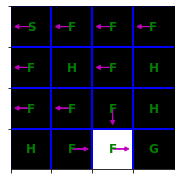

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


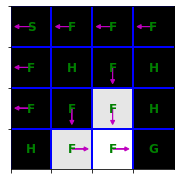

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


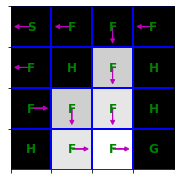

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


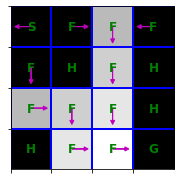

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


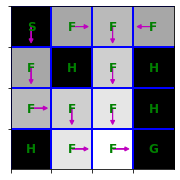

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


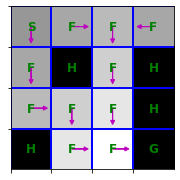

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 


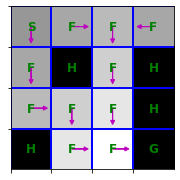

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 


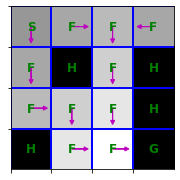

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 


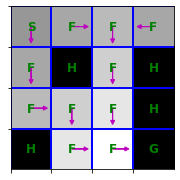

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


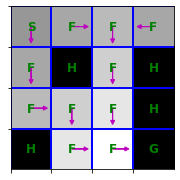

In [48]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 0
iter    0   |   diff: 0.90000   |   V(start): 0.000 


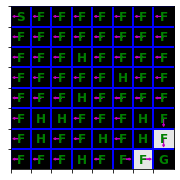

after iteration 1
iter    0   |   diff: 0.72900   |   V(start): 0.000 


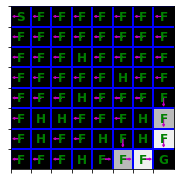

after iteration 2
iter    0   |   diff: 0.59049   |   V(start): 0.000 


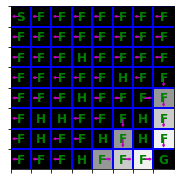

after iteration 3
iter    0   |   diff: 0.47830   |   V(start): 0.000 


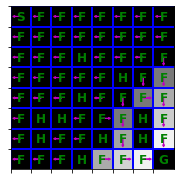

after iteration 4
iter    0   |   diff: 0.40894   |   V(start): 0.000 


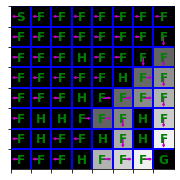

after iteration 5
iter    0   |   diff: 0.34868   |   V(start): 0.000 


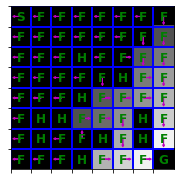

after iteration 6
iter    0   |   diff: 0.29655   |   V(start): 0.000 


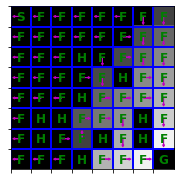

after iteration 7
iter    0   |   diff: 0.25292   |   V(start): 0.000 


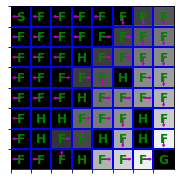

after iteration 8
iter    0   |   diff: 0.21619   |   V(start): 0.000 


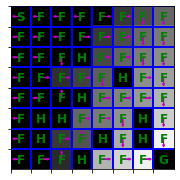

after iteration 9
iter    0   |   diff: 0.18482   |   V(start): 0.000 


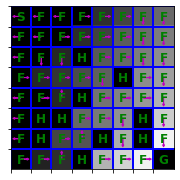

after iteration 10
iter    0   |   diff: 0.15757   |   V(start): 0.000 


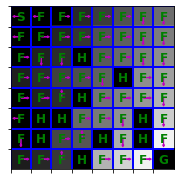

after iteration 11
iter    0   |   diff: 0.13430   |   V(start): 0.000 


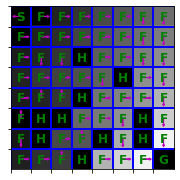

after iteration 12
iter    0   |   diff: 0.11445   |   V(start): 0.000 


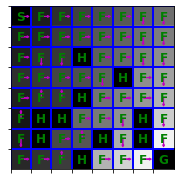

after iteration 13
iter    0   |   diff: 0.09751   |   V(start): 0.098 


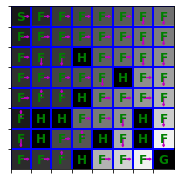

after iteration 14
iter    0   |   diff: 0.04772   |   V(start): 0.139 


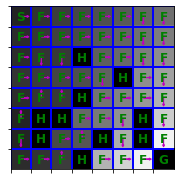

after iteration 15
iter    0   |   diff: 0.03479   |   V(start): 0.173 


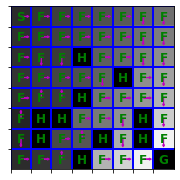

after iteration 16
iter    0   |   diff: 0.01283   |   V(start): 0.186 


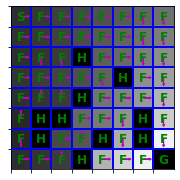

after iteration 17
iter    0   |   diff: 0.00734   |   V(start): 0.194 


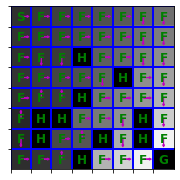

after iteration 18
iter    0   |   diff: 0.00255   |   V(start): 0.196 


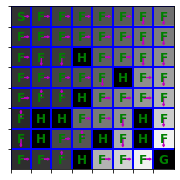

after iteration 19
iter    0   |   diff: 0.00125   |   V(start): 0.197 


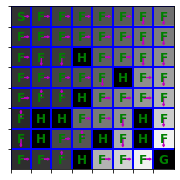

after iteration 20
iter    0   |   diff: 0.00042   |   V(start): 0.198 


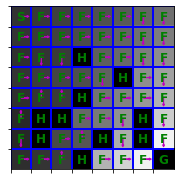

after iteration 21
iter    0   |   diff: 0.00019   |   V(start): 0.198 


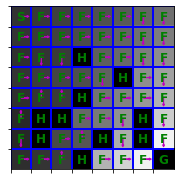

after iteration 22
iter    0   |   diff: 0.00006   |   V(start): 0.198 


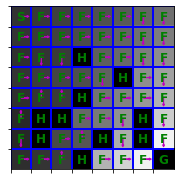

after iteration 23
iter    0   |   diff: 0.00003   |   V(start): 0.198 


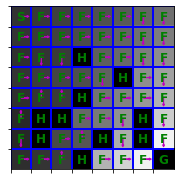

after iteration 24
iter    0   |   diff: 0.00001   |   V(start): 0.198 


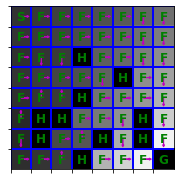

after iteration 25
iter    0   |   diff: 0.00000   |   V(start): 0.198 


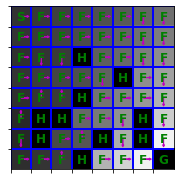

after iteration 26
iter    0   |   diff: 0.00000   |   V(start): 0.198 


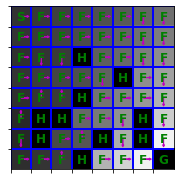

after iteration 27
iter    0   |   diff: 0.00000   |   V(start): 0.198 


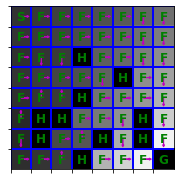

after iteration 28
iter    0   |   diff: 0.00000   |   V(start): 0.198 


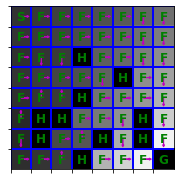

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


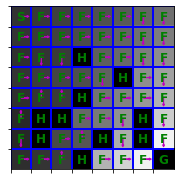

In [50]:
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)

# Home work

1 задание

In [51]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +1}},
    's2': {'a1': {'s0': 0}}
}


from numpy import random
mdp = MDP(transition_probs, rewards, initial_state=random.choice(tuple(transition_probs.keys())))

In [52]:

state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma=0.95)
                   for state in sorted(mdp.get_all_states())])

for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma=0.95)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    policy = new_policy

after iteration 0
iter    0   |   diff: 0.70000   |   V(start): 0.000 
N actions changed = 1 

after iteration 1
iter    0   |   diff: 0.18900   |   V(start): 0.000 
N actions changed = 1 

after iteration 2
iter    0   |   diff: 0.17010   |   V(start): 0.170 
N actions changed = 0 

after iteration 3
iter    0   |   diff: 0.12604   |   V(start): 0.247 
N actions changed = 0 

after iteration 4
iter    0   |   diff: 0.08611   |   V(start): 0.325 
N actions changed = 0 

after iteration 5
iter    0   |   diff: 0.07750   |   V(start): 0.403 
N actions changed = 0 

after iteration 6
iter    0   |   diff: 0.06834   |   V(start): 0.468 
N actions changed = 0 

after iteration 7
iter    0   |   diff: 0.05998   |   V(start): 0.528 
N actions changed = 0 

after iteration 8
iter    0   |   diff: 0.05399   |   V(start): 0.582 
N actions changed = 0 

after iteration 9
iter    0   |   diff: 0.04852   |   V(start): 0.630 
N actions changed = 0 

after iteration 10
iter    0   |   diff: 0.04359  

2 задание

In [54]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}


mdp = MDP(transition_probs, rewards, initial_state='s0')

In [55]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in state_values}

        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [56]:
state_values = value_iteration(mdp)

iter    0   |   diff: 3.50000   |   V(start): 0.000 
iter    1   |   diff: 1.89000   |   V(start): 0.000 
iter    2   |   diff: 1.70100   |   V(start): 1.701 
iter    3   |   diff: 1.13542   |   V(start): 1.854 
iter    4   |   diff: 0.73024   |   V(start): 2.584 
iter    5   |   diff: 0.61135   |   V(start): 3.186 
iter    6   |   diff: 0.54664   |   V(start): 3.590 
iter    7   |   diff: 0.49198   |   V(start): 4.082 
iter    8   |   diff: 0.42210   |   V(start): 4.463 
iter    9   |   diff: 0.36513   |   V(start): 4.816 
iter   10   |   diff: 0.32862   |   V(start): 5.145 
iter   11   |   diff: 0.29262   |   V(start): 5.429 
iter   12   |   diff: 0.26189   |   V(start): 5.691 
iter   13   |   diff: 0.23503   |   V(start): 5.925 
iter   14   |   diff: 0.21124   |   V(start): 6.135 
iter   15   |   diff: 0.19012   |   V(start): 6.325 
iter   16   |   diff: 0.17091   |   V(start): 6.496 
iter   17   |   diff: 0.15366   |   V(start): 6.649 
iter   18   |   diff: 0.13830   |   V(start): 

In [ ]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    <YOUR CODE>
    return <YOUR CODE>